In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Настройки

 - isolationForest_a = Загрязнение данных
 - ifgroup Группировка данных во временном интервале.
 - interval = Интервал при группировке 
 - step = Временной шаг для отношения к тому же кластеру
 - count_an = Минимальное число точечных аномалий для становления отрезком аномалии


In [2]:
isolationForest_a = [0.015, 0.02, 0.01, 0.01]
ifgroup = False
interval = '300s' 
step = 10
count_an = 2

# Загрузка данных

In [3]:
column_name = ['account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 'display_host', 'pid', 'agent_version', 'labels']

In [4]:
df = pd.read_csv('metrics_collector.tsv', sep='\t', header = None, names = column_name)

C:\Users\ggaa3\AppData\Local\Temp\ipykernel_13100\996938534.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metrics_collector.tsv', sep='\t', header = None, names = column_name)


# Функция поиска аномалий с помощью алгоритма "Изолированный Лес" со стандартизацией данных

In [5]:
def anomaly_finder_3000(data, a):
    anomaly_webr = data.set_index('point')

    scaler = StandardScaler()
    anomaly_webr_scaled = pd.DataFrame(scaler.fit_transform(anomaly_webr), index=anomaly_webr.index, columns=anomaly_webr.columns)

    model =  IsolationForest(contamination=float(a))
    model.fit(anomaly_webr_scaled.iloc[:, [0]])

    anomaly_webr_scaled['score'] = model.decision_function(anomaly_webr_scaled.iloc[:, [0]])
    anomaly_webr_scaled['anomaly_value'] = model.predict(anomaly_webr_scaled.iloc[:, [0]])

    a = anomaly_webr_scaled.loc[anomaly_webr_scaled['anomaly_value'] == -1, ['anomaly_value']] #anomaly

    return a

# Поиск аномалий в метриках

In [6]:
df_cr = df.copy()

In [7]:
df_WR = df_cr[['point','total_call_time','call_count']][(df_cr['language'] == 'java') &(df_cr['app_name'] == '[GMonit] Collector') & (df_cr['scope'].isnull()) & (df_cr['name'] == 'HttpDispatcher')]

In [8]:
df_webr = df_WR.groupby('point').agg({
    'total_call_time': lambda x: np.nan if x.isna().all() else x.sum(),
    'call_count': lambda x: np.nan if x.isna().all() else x.sum()
}).reset_index()
df_webr['y'] = df_webr['total_call_time'] / df_webr['call_count']
df_webr['webr_y'] = df_webr['y'] * 1000
df_webr['point'] = pd.to_datetime(df_webr['point'])
df_webr.set_index('point', inplace=True)

In [9]:
if ifgroup:
    grouped_webr = df_webr.groupby(pd.Grouper(freq=interval)).mean().reset_index()
else:
    grouped_webr = df_webr.reset_index() 
grouped_webr = grouped_webr[['point', 'webr_y']]

In [10]:
anomaly_webr = anomaly_finder_3000(grouped_webr.fillna(grouped_webr['webr_y'].median()), isolationForest_a[0])

C:\Users\ggaa3\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Задержка (ms)')

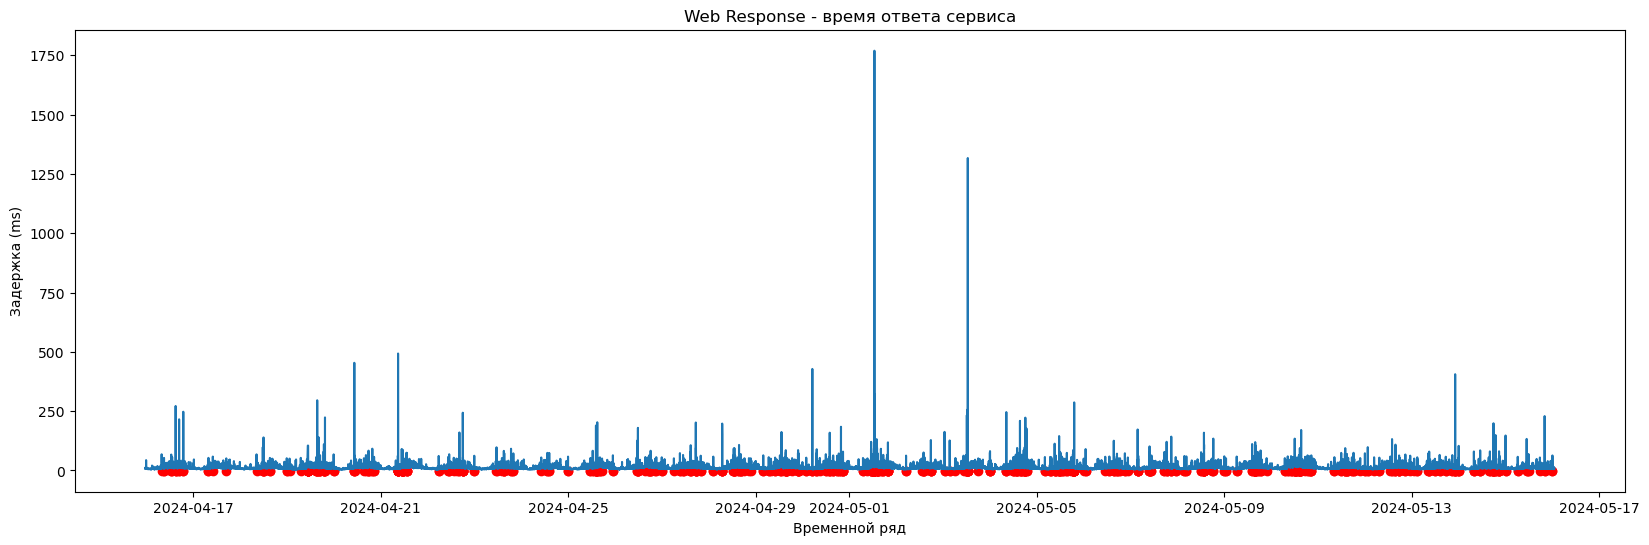

In [11]:
plt.figure(figsize=(20, 6))

sns.lineplot(x='point', y='webr_y', data=grouped_webr[['point','webr_y']])
plt.title('Web Response - время ответа сервиса')
plt.scatter(anomaly_webr.index, anomaly_webr['anomaly_value'], color='red', label = 'Anomaly')
plt.xlabel('Временной ряд')
plt.ylabel('Задержка (ms)')

In [12]:
df_T = df_cr[['point', 'call_count']][(df_cr['language'] == 'java') &(df_cr['app_name'] == '[GMonit] Collector') & (df_cr['scope'].isnull()) & (df_cr['name'] == 'HttpDispatcher')].fillna(0)

In [13]:
df_Tr = df_T.groupby('point').agg({
    'call_count': lambda x: np.nan if x.isna().all() else x.sum()
}).reset_index()

In [14]:
df_Tr['point'] = pd.to_datetime(df_Tr['point'])
df_Tr.set_index('point', inplace=True)
df_Tr['Tr_y'] = df_Tr['call_count']

if ifgroup:
    grouped_Tr = df_Tr.groupby(pd.Grouper(freq=interval)).mean().reset_index()
else:
    grouped_Tr = df_Tr.reset_index() 
grouped_Tr = grouped_Tr[['point', 'Tr_y']]

In [15]:
anomaly_Tr = anomaly_finder_3000(grouped_Tr.fillna(grouped_Tr['Tr_y'].median()),isolationForest_a[1])

C:\Users\ggaa3\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'RPM (запросы в минуту)')

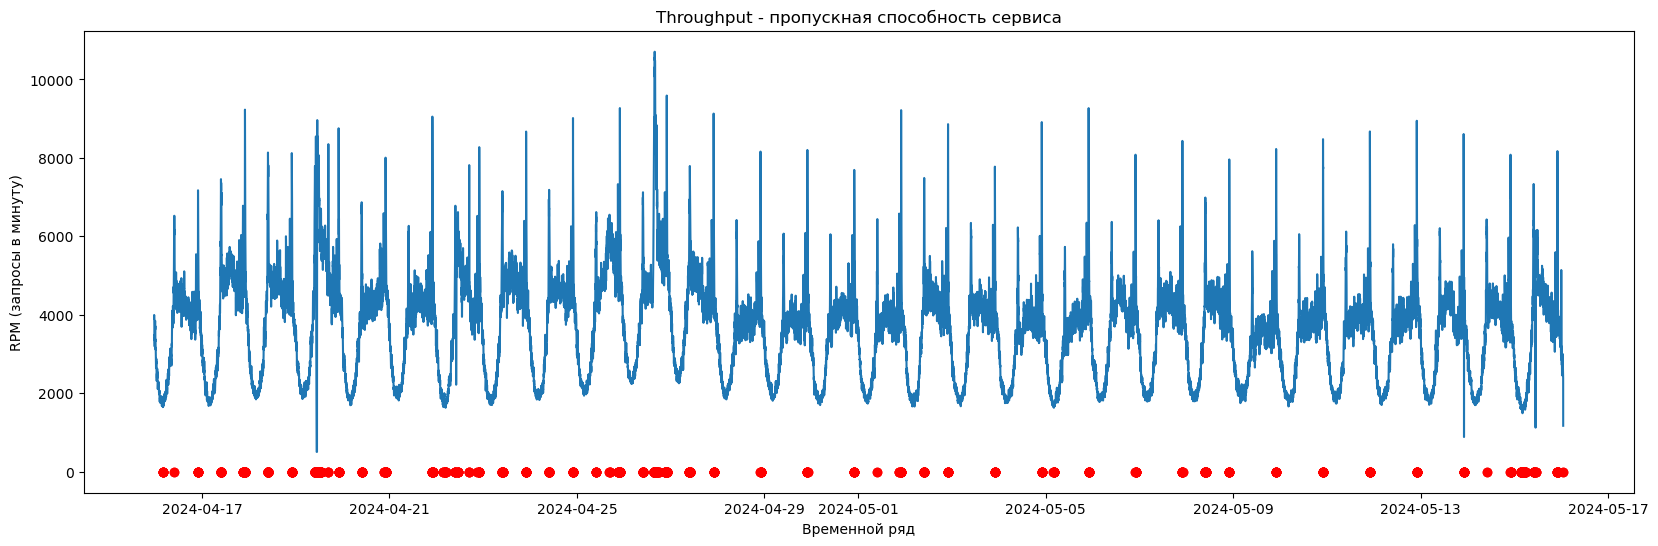

In [16]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Tr_y', data=grouped_Tr[['point','Tr_y']])
plt.scatter(anomaly_Tr.index, anomaly_Tr['anomaly_value'], color='red', label = 'Anomaly')
plt.scatter(anomaly_Tr.index, anomaly_Tr['anomaly_value'], color='red', label = 'Anomaly')
plt.title('Throughput - пропускная способность сервиса')
plt.xlabel('Временной ряд')
plt.ylabel('RPM (запросы в минуту)')

In [17]:
df_A = df_cr[['point', 'call_count', 'total_call_time', 'total_exclusive_time']][(df_cr['language'] == 'java') &(df_cr['app_name'] == '[GMonit] Collector') & (df_cr['scope'].isnull()) & (df_cr['name'] == 'Apdex')].fillna(0)
df_Ar = df_A.groupby('point').agg({
    'total_exclusive_time': lambda x: np.nan if x.isna().all() else x.sum(),
    'total_call_time': lambda x: np.nan if x.isna().all() else x.sum(),
    'call_count': lambda x: np.nan if x.isna().all() else x.sum()
}).reset_index()

In [18]:
df_Ar['Ar_y'] = (df_Ar['call_count'] + df_Ar['total_call_time']/2)/(df_Ar['call_count'] + df_Ar['total_call_time'] + df_Ar['total_exclusive_time'])
df_Ar['point'] = pd.to_datetime(df_Ar['point'])
df_Ar.set_index('point', inplace=True)

In [19]:
if ifgroup:
    grouped_Ar = df_Ar.groupby(pd.Grouper(freq=interval)).max().reset_index()
else:
    grouped_Ar = df_Ar.reset_index()
grouped_Ar = grouped_Ar[['point', 'Ar_y']]

In [20]:
anomaly_Ar = anomaly_finder_3000(grouped_Ar.fillna(grouped_Ar['Ar_y'].median()), isolationForest_a[2])
anomaly_Ar['anomaly_value'] = 1

C:\Users\ggaa3\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Показатель здоровья')

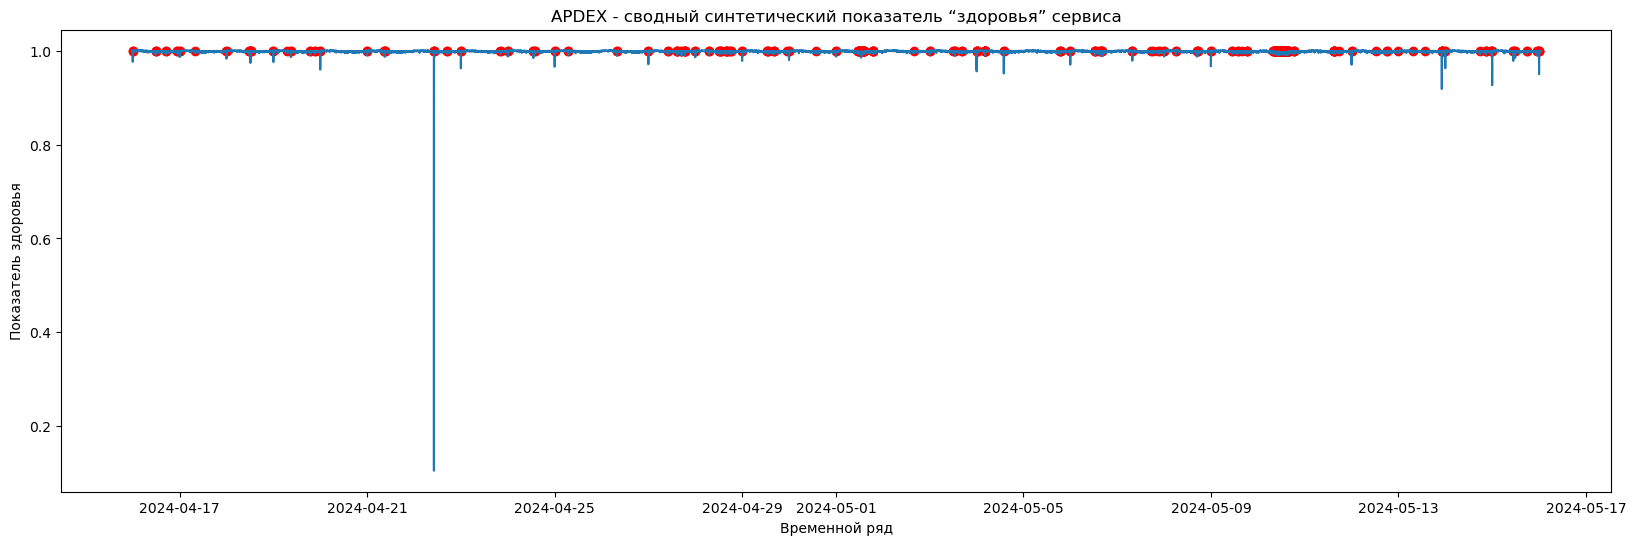

In [21]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Ar_y', data=grouped_Ar[['point','Ar_y']])
plt.scatter(anomaly_Ar.index, anomaly_Ar['anomaly_value'], color='red', label = 'Anomaly')
plt.title('APDEX - сводный синтетический показатель “здоровья” сервиса')
plt.xlabel('Временной ряд')
plt.ylabel('Показатель здоровья')

In [22]:
df_E = df_cr[['point', 'call_count', 'total_call_time', 'name']][(df_cr['language'] == 'java') &(df_cr['app_name'] == '[GMonit] Collector') & (df_cr['scope'].isnull()) & (df_cr['name'].isin(['HttpDispatcher', 'Errors/allWeb']))].fillna(0)

In [23]:
def sum_or_null_if(df, condition):
    filtered = df[condition]
    if filtered['call_count'].isna().all():
        return np.nan
    return filtered['call_count'].sum()

grouped = df_E.groupby('point')

results = grouped.apply(lambda x: pd.Series({
    ' ': sum_or_null_if(x, x['name'] == 'Errors/allWeb') / sum_or_null_if(x, x['name'] == 'HttpDispatcher')
}))

In [24]:
df_Er = results.reset_index()
df_Er[['point', 'Er_y']] = df_Er
df_Er = df_Er[['point', 'Er_y']]
df_Er['point'] = pd.to_datetime(df_Er['point'])
df_Er.set_index('point', inplace=True)

In [25]:
if ifgroup:
    grouped_Er = df_Er.groupby(pd.Grouper(freq=interval)).mean().reset_index()
else:
    grouped_Er = df_Er.reset_index() 

grouped_Er = grouped_Er[['point', 'Er_y']]

In [26]:
anomaly_Er = anomaly_finder_3000(grouped_Er.fillna(grouped_Er['Er_y'].median()), isolationForest_a[3])
anomaly_Er['anomaly_value'] = 0

C:\Users\ggaa3\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Процент ошибок')

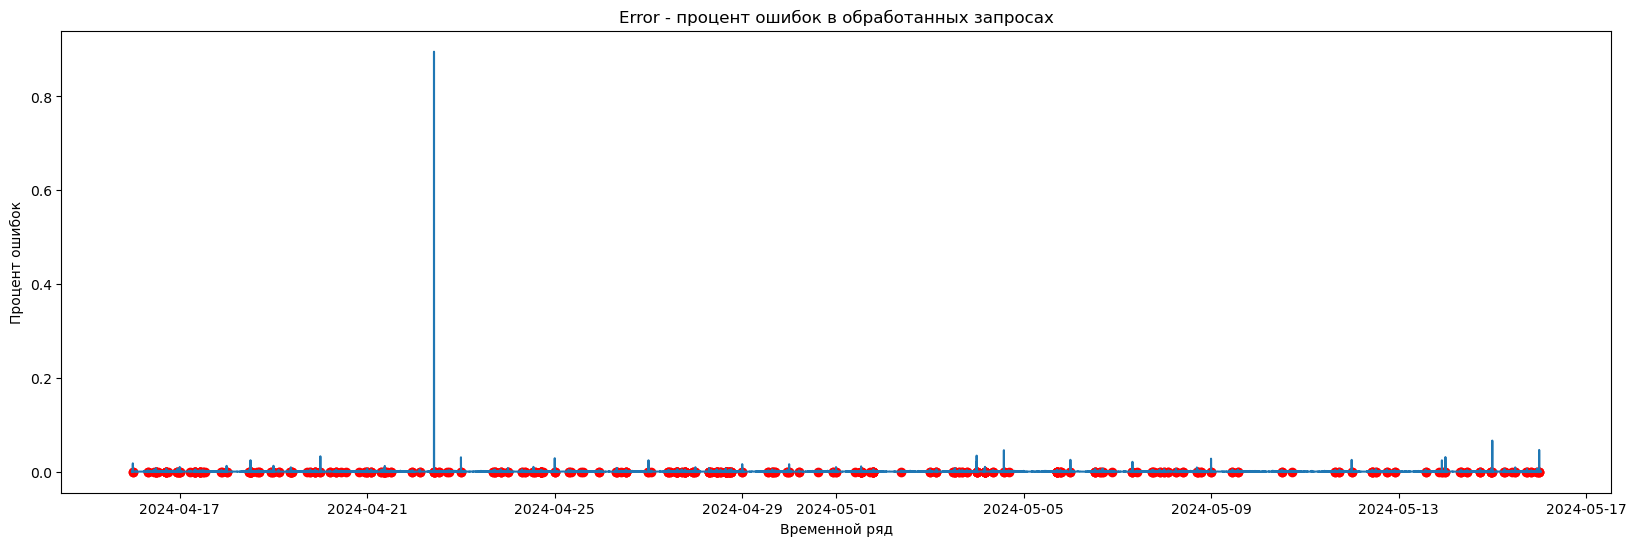

In [27]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='point', y='Er_y', data=grouped_Er[['point','Er_y']])
plt.scatter(anomaly_Er.index, anomaly_Er['anomaly_value'], color='red', label = 'Anomaly')
plt.title('Error - процент ошибок в обработанных запросах')
plt.xlabel('Временной ряд')
plt.ylabel('Процент ошибок')

# Кластеризируем аномалии с заданой длиной шага ближайшего соседа и минимальным кол-вом точек

In [28]:
anomaly_webr['anomaly_value'] = 1
anomaly_Tr['anomaly_value'] = 1
anomaly_Ar['anomaly_value'] = 1
anomaly_Er['anomaly_value'] = 1

anom = grouped_webr.copy()
anom = anom.set_index(['point'])
anom = anom.join(anomaly_webr['anomaly_value']).rename(columns={'anomaly_value':'webr_anom'})
anom = anom.join(anomaly_Tr['anomaly_value']).rename(columns={'anomaly_value':'Tr_anom'})
anom = anom.join(anomaly_Ar['anomaly_value']).rename(columns={'anomaly_value':'Ar_anom'})
anom = anom.join(anomaly_Er['anomaly_value']).rename(columns={'anomaly_value':'Er_anom'})
anom = anom.drop(columns=['webr_y'])
anom = anom.replace(np.NaN, 0)

In [29]:
def cluster_3000(data):
    df = pd.DataFrame(data.reset_index())
    df['point'] = pd.to_datetime(df['point'])
    df.iloc[:, [1]] = df.iloc[:, [1]].squeeze().astype(int)
    df['cluster'] = np.nan

    df_ones = df[df.iloc[:, [1]].squeeze() == 1].sort_values('point').reset_index()

    cluster_id = 1
    previous_point = None

    for idx, row in df_ones.iterrows():
        current_point = row['point']
        if previous_point is None or (current_point - previous_point).total_seconds() / 60 > step:
            cluster_id += 1
        df.loc[row['index'], 'cluster'] = cluster_id
        previous_point = current_point
    cluster_counts = df['cluster'].value_counts()
    small_clusters = cluster_counts[cluster_counts <= count_an].index
    df.loc[df['cluster'].isin(small_clusters), 'cluster'] = np.nan
    
    return df.set_index('point').iloc[:, [1]]

In [30]:
def min_max_dates(group):
    min_date = group[group.iloc[:, [1]] == 1.0].index.min()
    max_date = group[group.iloc[:, [1]] == 1.0].index.max()
    group['min'] = min_date
    group['max'] = max_date
    group['cluster'] = group.iloc[:, [1]]
    return group

In [31]:
anom['webr_anom_claster']= cluster_3000(anom.iloc[:, [0]])
anom['Tr_anom_anom_claster'] = cluster_3000(anom.iloc[:, [1]])
anom['Ar_anom_anom_claster'] = cluster_3000(anom.iloc[:, [2]])
anom['Er_anom_anom_claster'] = cluster_3000(anom.iloc[:, [3]])

somedf_1 = anom.iloc[:, [0, 4]].groupby(anom.columns[4]).apply(min_max_dates)
somedf_2 = anom.iloc[:, [1, 5]].groupby(anom.columns[5]).apply(min_max_dates)
somedf_3 = anom.iloc[:, [2, 6]].groupby(anom.columns[6]).apply(min_max_dates)
somedf_4 = anom.iloc[:, [3, 7]].groupby(anom.columns[7]).apply(min_max_dates)

C:\Users\ggaa3\AppData\Local\Temp\ipykernel_13100\2554951717.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between([w[2], w[3]], i*mmx/5, (i+1)*mmx/5, color=colors[i], alpha=0.5, label='Interval', edgecolor=colors[i])


webr_anom_claster    61
dtype: int64


C:\Users\ggaa3\AppData\Local\Temp\ipykernel_13100\2554951717.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between([w[2], w[3]], i*mmx/5, (i+1)*mmx/5, color=colors[i], alpha=0.5, label='Interval', edgecolor=colors[i])


Tr_anom_anom_claster    57
dtype: int64


C:\Users\ggaa3\AppData\Local\Temp\ipykernel_13100\2554951717.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between([w[2], w[3]], i*mmx/5, (i+1)*mmx/5, color=colors[i], alpha=0.5, label='Interval', edgecolor=colors[i])


Ar_anom_anom_claster    31
dtype: int64
Er_anom_anom_claster    40
dtype: int64


C:\Users\ggaa3\AppData\Local\Temp\ipykernel_13100\2554951717.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.fill_between([w[2], w[3]], i*mmx/5, (i+1)*mmx/5, color=colors[i], alpha=0.5, label='Interval', edgecolor=colors[i])


Text(0.5, 0, 'Временной ряд')

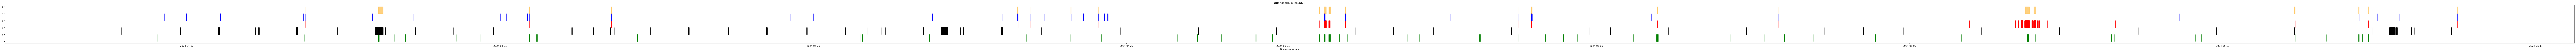

In [32]:
dfs = {'Web Response': somedf_1, 'Throughput': somedf_2, 'APDEX': somedf_3, 'Error': somedf_4}
combined_df = pd.concat(dfs.values(), keys=dfs.keys())
combined_df.sort_values(by=['min', 'max'], inplace=True)

intersections = []

current_min = combined_df.iloc[0]['min']
current_max = combined_df.iloc[0]['max']
current_dataframes = [combined_df.index[0][0]]
for index, row in combined_df.iterrows():
    if row['min'] <= current_max + pd.Timedelta(minutes=3):   # 3 минутная дельта синтетически расширяет аномалию
        current_max = max(current_max, row['max'])
        if index[0] not in current_dataframes:
            current_dataframes.append(index[0])
    else:  
        if len(current_dataframes) > 1:  
            intersections.append((current_min, current_max, current_dataframes)) 
        current_min = row['min']
        current_max = row['max']
        current_dataframes = [index[0]]

if len(current_dataframes) > 1:
    intersections.append((current_min, current_max, current_dataframes))

plt.figure(figsize=(200, 3))
colors = ['green','black','red','blue']
mmx = 5

for i in range(4):
    somedf = anom.iloc[:, [i, i+4]].groupby(anom.columns[i+4]).apply(min_max_dates)


    for q,w in somedf.iterrows():
        plt.fill_between([w[2], w[3]], i*mmx/5, (i+1)*mmx/5, color=colors[i], alpha=0.5, label='Interval', edgecolor=colors[i])
    print(somedf.iloc[:, [1]].nunique())  

for interval in intersections:
    plt.fill_between([interval[0], interval[1]], mmx-mmx/5, mmx, color='orange', alpha=0.5, edgecolor='orange')
plt.title('Диапазоны аномалий')

plt.xlabel('Временной ряд')

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


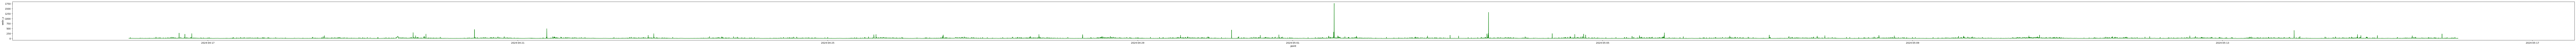

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


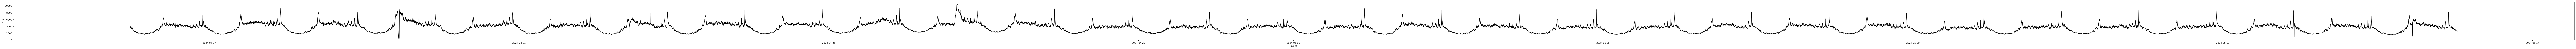

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


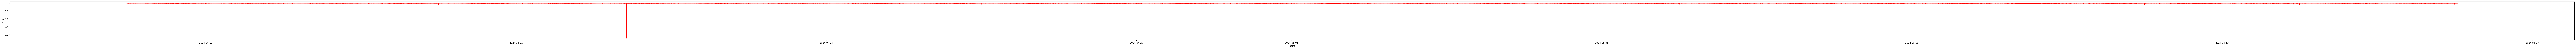

C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ggaa3\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


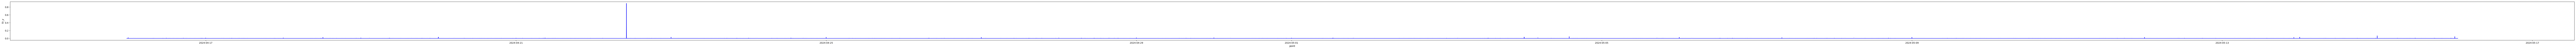

In [33]:
plt.figure(figsize=(200, 3))
sns.lineplot(x='point', y='webr_y', data=grouped_webr[['point','webr_y']], color='green')
plt.show()
plt.figure(figsize=(200, 3))
sns.lineplot(x='point', y='Tr_y', data=grouped_Tr[['point','Tr_y']], color='black')
plt.show()
plt.figure(figsize=(200, 3))
sns.lineplot(x='point', y='Ar_y', data=grouped_Ar[['point','Ar_y']], color='red')
plt.show()
plt.figure(figsize=(200, 3))
sns.lineplot(x='point', y='Er_y', data=grouped_Er[['point','Er_y']], color='blue')
plt.show()

# На выходе программы выгружаем csv файл, где каждая строка - Временной отрезок и связанные с ним аномалии в метриках

In [34]:
result = pd.DataFrame(intersections)
result.columns = [['min','max','metrics']]
result.to_csv('result.csv')
result

,min,max,metrics
0,2024-04-16 11:46:00,2024-04-16 11:50:00,"[Error, APDEX]"
1,2024-04-18 12:13:00,2024-04-18 12:19:00,"[APDEX, Error]"
2,2024-04-19 10:43:00,2024-04-19 12:11:00,"[Web Response, Throughput]"
3,2024-04-21 08:51:00,2024-04-21 09:02:00,"[Web Response, APDEX, Error]"
4,2024-04-22 10:10:00,2024-04-22 10:13:00,"[APDEX, Error]"
5,2024-04-27 14:34:00,2024-04-27 14:49:00,"[Error, APDEX]"
6,2024-04-27 18:40:00,2024-04-27 18:46:00,"[APDEX, Error]"
7,2024-04-28 06:55:00,2024-04-28 07:02:00,"[Web Response, Error]"
8,2024-04-28 15:26:00,2024-04-28 15:34:00,"[Error, APDEX]"
9,2024-05-01 11:07:00,2024-05-01 11:15:00,"[Web Response, APDEX]"
